# Kernel Density Estimation
##### Ing.Luis Felipe Narvaez Gomez. E-mail: luis.narvaez@usantoto.edu.co. Cod: 2312660. Facultad de Ingenieria de Sistemas. USTA.

References:
https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

En la guia anterior de GMM, la cual es una especie de híbrido entre un estimador de agrupamiento y un estimador de densidad.

***Recuerde que un estimador de densidad es un algoritmo que toma unaD-conjunto de datos dimensional y produce una estimación de laDdistribución de probabilidad dimensional de la que se extraen los datos. El algoritmo GMM logra esto al representar la densidad como una suma ponderada de distribuciones gaussianas.***


La estimación de la densidad del núcleo (KDE) es, en algunos sentidos, un algoritmo que lleva la idea de la mezcla de gaussianas a su extremo lógico, utiliza una mezcla que consta de un componente gaussiano por punto , lo que da como resultado un estimador de densidad esencialmente no paramétrico. En esta sección, exploraremos la motivación y los usos de KDE.

 Primero importemos las librerias necesarias

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [3]:
from IPython.display import Image

### KDE en Histogramas

Como ya se discutió, un estimador de densidad es un algoritmo que busca modelar la distribución de probabilidad que generó un conjunto de datos.

Para datos unidimensionales, probablemente ya esté familiarizado con un estimador de densidad simple: el histograma.

Un histograma divide los datos en contenedores discretos, cuenta la cantidad de puntos que caen en cada contenedor y luego visualiza los resultados de una manera intuitiva.

Por ejemplo, creemos algunos datos extraídos de dos distribuciones normales:

<span style="color:red">Por curiosidad, puede que KDE este basado de alguna forma en Montecarlo y el teorema del limite Central /(°^°)/ </span>

In [4]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

Anteriormente hemos visto que el histograma estándar basado en recuento se puede crear con la funcion ***plt.hist()***.

Al especificar el **normed** parámetro del histograma, obtenemos un histograma normalizado en el que la altura de los contenedores no refleja los recuentos, sino la densidad de probabilidad:

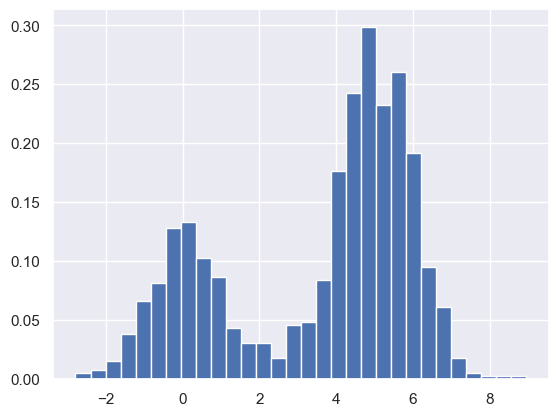

In [6]:
# hist = plt.hist(x, bins=30, normed=True)
# https://stdworkflow.com/67/attributeerror-rectangle-object-has-no-property-normed-solution
"""
Change normed attribute in the code to density
then also add an attribute stacked = True

    density=True represents the frequency distribution
    density=False represents the probability density distribution

"""
    

hist = plt.hist(x, bins=30, density=True, stacked=True )

Tenga en cuenta que para la distribución equitativa, esta normalización simplemente cambia la escala en el eje y, dejando las alturas relativas esencialmente iguales que en un histograma creado a partir de conteos.

Esta normalización se elige para que el área total bajo el histograma sea igual a 1, como podemos confirmar mirando la salida de la función de histograma:

In [7]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

Uno de los problemas con el uso de un histograma como estimador de densidad es que la elección del tamaño y la ubicación del contenedor puede conducir a representaciones que tienen características cualitativamente diferentes.

 Por ejemplo, si observamos una versión de estos datos con solo 20 puntos, la elección de cómo dibujar los contenedores puede conducir a una interpretación completamente diferente de los datos. Considere este ejemplo:

In [8]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

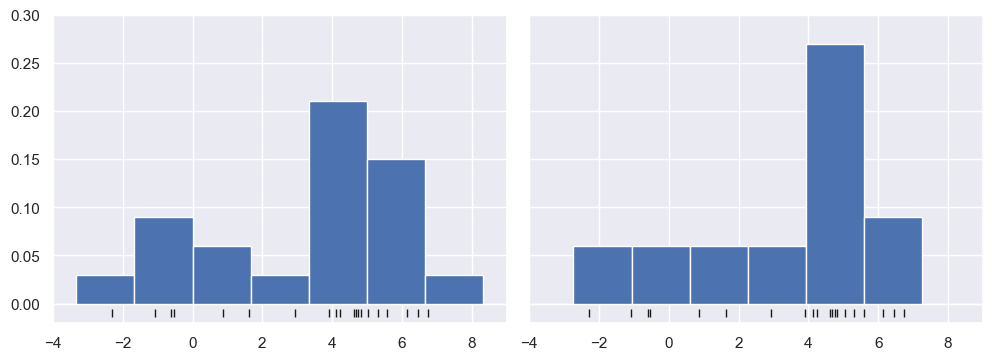

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),sharex=True, sharey=True, subplot_kw={'xlim':(-4, 9),'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)

for i, offset in enumerate([0.0, 0.6]):
    #ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].hist(x, bins=bins + offset, density=True, stacked=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

A la izquierda, el histograma deja claro que se trata de una distribución bimodal. A la derecha, vemos una distribución unimodal con una cola larga.

Sin ver el código anterior, probablemente no adivinaría que estos dos histogramas se construyeron a partir de los mismos datos; con eso en mente, ¿cómo puede confiar en la intuición que confieren los histogramas? ¿Y cómo podríamos mejorar esto?

Retrocediendo, podemos pensar en un histograma como una pila de bloques, donde apilamos un bloque dentro de cada contenedor encima de cada punto en el conjunto de datos.

Veamos esto directamente:


(-0.2, 8.0)

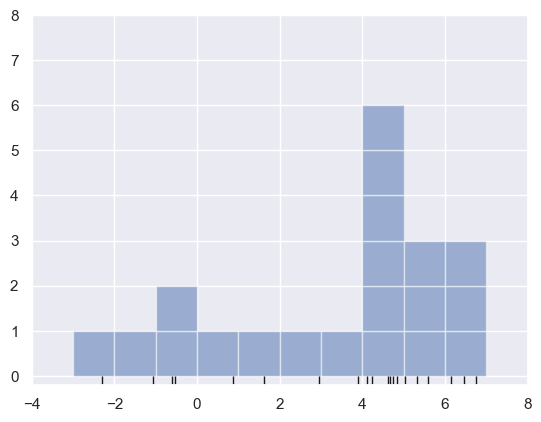

In [11]:
fig, ax = plt.subplots()

bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
        
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

El problema con nuestros dos agrupamientos surge del hecho de que la altura de la pila de bloques a menudo no se refleja en la densidad real de los puntos cercanos, sino en las coincidencias de cómo los agrupamientos se alinean con los puntos de datos.

Esta desalineación entre los puntos y sus bloques es una causa potencial de los malos resultados del histograma que se ven aquí.

Pero, ¿y si, en lugar de apilar los bloques alineados con los contenedores , apiláramos los bloques alineados con los puntos que representan ? Si hacemos esto, los bloques no estarán alineados, pero podemos sumar sus contribuciones en cada ubicación a lo largo del eje x para encontrar el resultado.



(-4.0, 8.0, -0.2, 8.0)

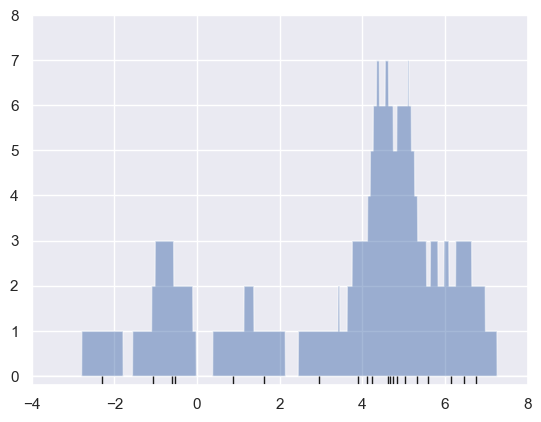

In [12]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8])

El resultado parece un poco desordenado, pero es un reflejo mucho más sólido de las características de los datos reales que el histograma estándar.

Aún así, los bordes ásperos no son estéticamente agradables, ni reflejan ninguna propiedad real de los datos.

Para suavizarlos, podríamos decidir reemplazar los bloques en cada ubicación con una función suave, como una gaussiana. Usemos una curva normal estándar en cada punto en lugar de un bloque:

(-4.0, 8.0, -0.2, 5.0)

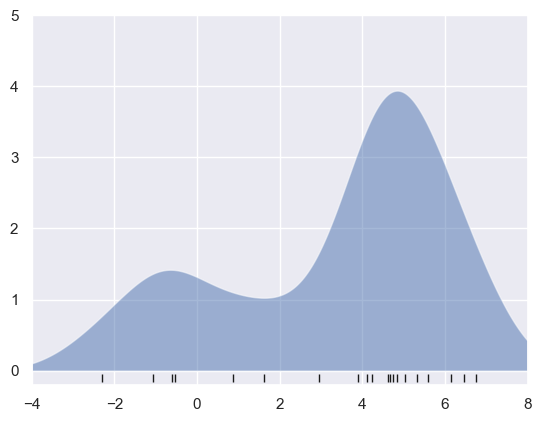

In [13]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5])

Este gráfico suavizado, con una distribución gaussiana aportada en la ubicación de cada punto de entrada, da una idea mucho más precisa de la forma de la distribución de datos y una que tiene mucha menos variación (es decir, cambia mucho menos en respuesta a las diferencias en el muestreo).

Estos dos últimos gráficos son ejemplos de estimación de la densidad del kernel en una dimensión; el primero usa el llamado kernel "tophat" y el segundo usa un kernel gaussiano. Ahora veremos la estimación de la densidad del kernel con más detalle.

### Estimacion de la densidad del Cluster en la practica

Los parámetros libres de estimación de la densidad del núcleo son el núcleo , que especifica la forma de la distribución colocada en cada punto, y el ancho de banda del núcleo , que controla el tamaño del núcleo en cada punto.

En la práctica, hay muchos núcleos que puede usar para una estimación de la densidad del núcleo: en particular, la implementación de KDE de Scikit-Learn admite uno de los seis núcleos, sobre los que puede leer en la documentación de Estimación de la densidad de Scikit-Learn .

Si bien hay varias versiones de la estimación de la densidad del núcleo implementadas en Python (especialmente en los paquetes SciPy y StatsModels), prefiero usar la versión de Scikit-Learn debido a su eficiencia y flexibilidad.

Se implementa en el **sklearn.neighbors.KernelDensity** estimador, que maneja KDE en múltiples dimensiones con uno de seis núcleos y uno de un par de docenas de métricas de distancia. 

Debido a que KDE puede ser bastante intensivo desde el punto de vista computacional, el estimador Scikit-Learn utiliza un algoritmo basado en árboles bajo el capó y puede compensar el tiempo de cálculo por la precisión utilizando los parámetros **atol**(tolerancia absoluta) y **rtol**(tolerancia relativa).

El ancho de banda del núcleo, que es un parámetro gratuito, se puede determinar utilizando las herramientas de validación cruzada estándar de Scikit-Learn, como veremos pronto.

Primero mostremos un ejemplo simple de replicar la gráfica anterior usando el **KernelDensity** estimador Scikit-Learn:

(-0.02, 0.22)

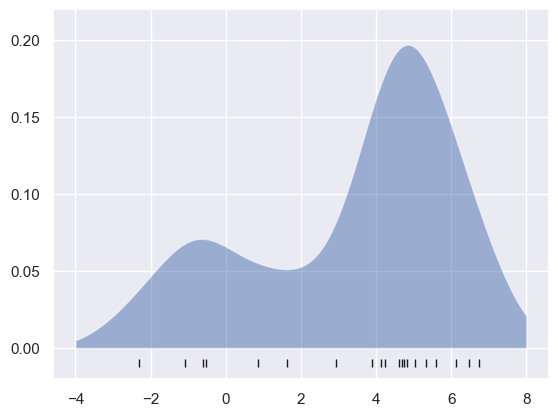

In [14]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

El resultado aquí se normaliza de tal manera que el área bajo la curva es igual a 1.

### Seleccion del ancho de Banda mediante validacion cruzada

La elección del ancho de banda dentro de KDE es extremadamente importante para encontrar una estimación de densidad adecuada, y es la perilla que controla el equilibrio entre sesgo y varianza en la estimación de densidad; un ancho de banda demasiado estrecho conduce a una estimación de varianza alta (es decir, sobre -fitting), donde la presencia o ausencia de un solo punto hace una gran diferencia.

Un ancho de banda demasiado amplio conduce a una estimación de alto sesgo (es decir, ajuste insuficiente) donde la estructura de los datos es eliminada por el kernel ancho.

Hay una larga historia en estadísticas de métodos para estimar rápidamente el mejor ancho de banda basado en suposiciones bastante estrictas sobre los datos; si busca las implementaciones de KDE en los paquetes SciPy y StatsModels, por ejemplo, verá implementaciones basadas en algunos de estos normas.

En contextos de aprendizaje automático, hemos visto que tal ajuste de hiperparámetros a menudo se realiza empíricamente a través de un enfoque de validación cruzada.

Con esto en mente, el **KernelDensity** estimador en Scikit-Learn está diseñado de tal manera que se puede usar directamente dentro de las herramientas de búsqueda de cuadrícula estándar de Scikit-Learn.

Aquí lo utilizaremos **GridSearchCV** para optimizar el ancho de banda para el conjunto de datos anterior. Debido a que estamos viendo un conjunto de datos tan pequeño, utilizaremos la validación cruzada de exclusión, que minimiza la reducción en el tamaño del conjunto de entrenamiento para cada prueba de validación cruzada:

In [19]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

#from sklearn.cross_validation import LeaveOneOut
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
#grid = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidths}, cv=LeaveOneOut(len(x)))
grid = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidths})
grid.fit(x[:, None])

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.3...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

Ahora podemos encontrar la opción de ancho de banda que maximiza la puntuación (que en este caso tiene como valor predeterminado la probabilidad logarítmica):

In [20]:
grid.best_params_

{'bandwidth': 1.291549665014884}

El ancho de banda óptimo resulta estar muy cerca de lo que usamos en el gráfico de ejemplo anterior, donde el ancho de banda era 1,0 (es decir, el ancho predeterminado de **scipy.stats.norm**).